In [50]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from matplotlib import rc
import pandas as pd
import os.path as path
from tqdm import tqdm
import scipy
from scipy.stats import linregress
from scipy.integrate import quad, dblquad
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

In [51]:
file1 = 'Doble Rendija 0.457 Laser.csv'
Data = pd.read_csv(file1, sep=';')
mm = np.float64(Data['0.457mm'])/1000
Vdobleoffset = np.float64(Data['Vdobleoffset'])
Vsencoffset = np.float64(Data['Vsencillaoffset'])

In [52]:
def integral(f_r, f_i, a, b):
    real = quad(f_r, a, b)
    im = quad(f_i, a, b)
    return complex(real[0], im[0])

# Parametros
a = 0.0001
x = 0
d = 0.000457
D1 = 0.5
D2 = 0.5

def fresnelfeynmandoble(z,lambda_g,b, p):
    I=[]
    for i in range(len(z)):
    # Intensidad
        di_real= lambda y: np.cos(np.pi/(D1*lambda_g)*(x-y)**2 + np.pi/(D2*lambda_g)*(z[i]-p-y)**2)
        di_img= lambda y: np.sin(np.pi/(D1*lambda_g)*(x-y)**2 + np.pi/(D2*lambda_g)*(z[i]-p-y)**2)
    
    # Intensidad Rendija izquierda
        i_izq= np.exp(2*np.pi*1j*(D1+D2)/lambda_g)*integral(di_real, di_img,-d/2-a/2, -d/2+a/2)
    
    # Intensidad Rendija derecha
        i_der= np.exp(2*np.pi*1j*(D1+D2)/lambda_g)*integral(di_real, di_img, d/2-a/2, d/2+a/2)
        I.append(abs(i_der + i_izq)**2*b)
    return np.array(I)

def fresnelfeynmansenc(z,lambda_g,b, p):
    I=[]
    for i in range(len(z)):
    # Intensidad
        di_real= lambda y: np.cos(np.pi/(D1*lambda_g)*(x-y)**2 + np.pi/(D2*lambda_g)*(z[i]-p-y)**2)
        di_img= lambda y: np.sin(np.pi/(D1*lambda_g)*(x-y)**2 + np.pi/(D2*lambda_g)*(z[i]-p-y)**2)
    
    # Intensidad Rendija derecha
        i_der= np.exp(2*np.pi*1j*(D1+D2)/lambda_g)*integral(di_real, di_img, d/2-a/2, d/2+a/2)
        I.append(abs(i_der)**2*b)
    return np.array(I)
    

In [53]:
guess=[580*10**(-9),10**(8), 0.0043]

parametros1, covarianza1 = curve_fit(fresnelfeynmandoble, mm[15:], Vdobleoffset[15:], p0=guess)
parametros2, covarianza2 = curve_fit(fresnelfeynmansenc, mm, Vsencoffset, p0=guess)
incertidumbre1 = np.sqrt(np.diag(covarianza1))
incertidumbre2 = np.sqrt(np.diag(covarianza2))
print(parametros1, parametros2)
print(incertidumbre1, incertidumbre2)

[6.60603583e-07 2.74303637e+07 4.42426430e-03] [7.16206922e-07 2.85790927e+07 5.13535864e-03]
[2.19852530e-09 3.76279378e+05 2.75939432e-06] [3.14289188e-09 1.17190245e+05 6.26879431e-06]


In [54]:
mm_values = np.linspace(0.0, 0.009, 1000)
Vdoble = fresnelfeynmandoble(mm_values, parametros1[0], parametros1[1], parametros1[2]) 
Vsenc = fresnelfeynmansenc(mm_values, parametros2[0], parametros2[1], parametros2[2]) 

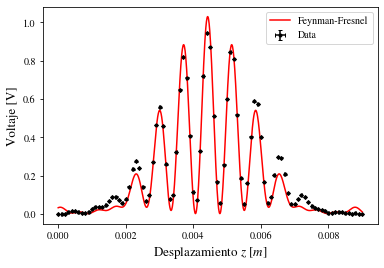

In [55]:
plt.xlabel(r'Desplazamiento $z$ [$m$]', fontsize=13, color='black')
plt.ylabel('Voltaje [V]', fontsize=13, color='black')
plt.tick_params(axis='both', colors='black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.errorbar(mm, Vdobleoffset, yerr = 0.001, xerr = 5e-6, fmt = '.', capsize=2, label = 'Data', c='k')
plt.plot(mm_values, Vdoble, color = 'r', label = 'Feynman-Fresnel')
plt.legend()
plt.savefig('DobleRendija0.457.png', dpi=1000)

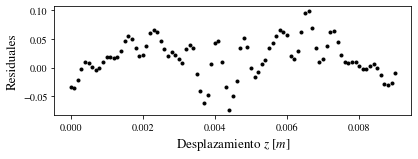

In [56]:
#Residuales
plt.figure(figsize=(6.4,2))
plt.xlabel(r'Desplazamiento $z$ [$m$]', fontsize=13, color='black')
plt.ylabel('Residuales', fontsize=13, color='black')
plt.tick_params(axis='both', colors='black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.scatter(mm, (Vdobleoffset - fresnelfeynmandoble(mm, parametros1[0], parametros1[1], parametros1[2])), color = 'k', marker = '.')
plt.savefig('DobleRendija0.457Res.png', dpi=1000, bbox_inches='tight')

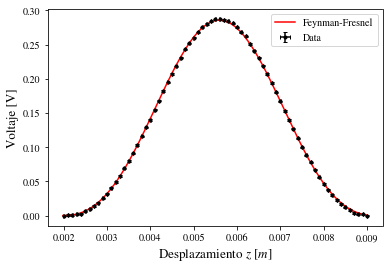

In [57]:
plt.xlabel(r'Desplazamiento $z$ [$m$]', fontsize=13, color='black')
plt.ylabel('Voltaje [V]', fontsize=13, color='black')
plt.tick_params(axis='both', colors='black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.errorbar(mm[20:], Vsencoffset[20:], yerr = 0.001, xerr = 5e-6, fmt = '.', capsize=2, label = 'Data', c='k')
plt.plot(mm_values[220:], Vsenc[220:], color = 'r', label = 'Feynman-Fresnel')
plt.legend()
plt.savefig('RendijaDerecha0.457.png', dpi=1000)

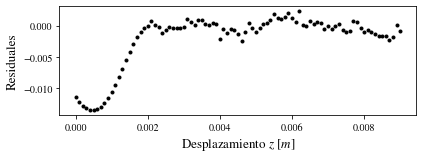

In [58]:
#Residuales
plt.figure(figsize=(6.4,2))
plt.xlabel(r'Desplazamiento $z$ [$m$]', fontsize=13, color='black')
plt.ylabel('Residuales', fontsize=13, color='black')
plt.tick_params(axis='both', colors='black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.scatter(mm, (Vsencoffset - fresnelfeynmansenc(mm, parametros2[0], parametros2[1], parametros2[2])), color = 'k', marker = '.')
plt.savefig('RendijaDerecha0.457Res.png', dpi=1000, bbox_inches='tight')